<a href="https://colab.research.google.com/github/Annie-Yeeun-Jang/text_style_transfer_Tobigs/blob/main/coca_preprocessing_(web%2C%20news).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Preprocessing

In [ ]:
import seaborn as sns
import re
import nltk 
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
folder_name = "/content/drive/Shareddrives/text_conf/dataset/COCA/coca-samples-text/"
file_name_list = ["text_fic.txt", "text_tvm.txt", "text_web.txt", 'text_news.txt']
file_list = {}
for file in file_name_list:
  with open(f"{folder_name}/{file}", encoding = 'UTF-8', newline = '\n') as f:
    data = []
    for line in f.readlines():
      if 'href' not in line:
        data.append(line)
    file_list[file[5:8]] = data[1:]

In [ ]:
# https://stackoverflow.com/questions/4576077/how-can-i-split-a-text-into-sentences
# sentence splitter function
alphabets= "([A-Za-z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt|Jr)[.]"
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
starters = "(Mr|Mrs|Ms|Dr|He\s|She \s|It \s|They \re|Their\s|Our\s|We\s|But\s|However\s|That\s|This\s|Wherever)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
websites = "[.](com|net|org|io|gov|me|edu)"

def split_into_sentences(text):
    text = " " + text + "  "
    text = text.replace("\n"," ")
    text = re.sub(prefixes,"\\1<prd>",text)
    text = re.sub(websites,"<prd>\\1",text)
    if "Ph.D" in text: text = text.replace("Ph.D.","Ph<prd>D<prd>")
    text = re.sub("\s" + alphabets + "[.] "," \\1<prd> ",text)
    text = re.sub(acronyms+" "+starters,"\\1<stop> \\2",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>\\3<prd>",text)
    text = re.sub(alphabets + "[.]" + alphabets + "[.]","\\1<prd>\\2<prd>",text)
    text = re.sub(" "+suffixes+"[.] "+starters," \\1<stop> \\2",text)
    text = re.sub(" "+suffixes+"[.]"," \\1<prd>",text)
    text = re.sub(" " + alphabets + "[.]"," \\1<prd>",text)
    if "”" in text: text = text.replace(".”","”.")
    if "\"" in text: text = text.replace(".\"","\".")
    if "!" in text: text = text.replace("!\"","\"!")
    if "?" in text: text = text.replace("?\"","\"?")
    if "..." in text: text = text.replace("...","<prd><prd><prd>")
    text = text.replace(".",".<stop>")
    text = text.replace("?","?<stop>")
    text = text.replace("!","!<stop>")
    text = text.replace("<prd>",".")
    sentences = text.split("<stop>")
    sentences = sentences[:-1]
    sentences = [s.strip() for s in sentences]
    return sentences

In [ ]:
def html_preprocessing(corpus):
  # html 기호들 전처리 
  corpus = re.sub("&nbsp;", " ", corpus)
  corpus = re.sub("&It;", "<", corpus)
  corpus = re.sub("%amp;", "and", corpus)
  corpus = re.sub("quot;", '"', corpus)
  corpus = re.sub("&#035;", "#", corpus)
  corpus = re.sub("&#039;", "'", corpus)

  return corpus

def preprocessing(corpus, sentence_splitter = split_into_sentences):
  # 전처리 코드 전체 
  # input : 문서 리스트
  # output : 문서 리스트
  corpus = html_preprocessing(corpus)
  corpus = re.sub(r"@@[0-9]{7}", "", corpus)
  corpus = re.sub(r"\<.\>", "", corpus) # <p>나 <h> 삭제 
  corpus = re.sub(r"[0-9]", "#NUM", corpus) # 2020년 01월 -> ####년 ##월
  corpus = re.sub(r"\( ?.* ?\)", "", corpus) # 괄호 안 문장 삭제라 조심해서 사용할 것. 
  corpus_split_by_sent = sentence_splitter(corpus) # 문장 단위로 나눔.  #I.A.E.E 나 C.I.A.를 문장으로 끊고 있음
  # corpus_split_by_sent[0] = re.sub("@@#NUM#NUM#NUM#NUM#NUM#NUM#NUM  ",  "", corpus_split_by_sent[0]) # corpus_id를 지움
  result_corpus = []
  for sent in corpus_split_by_sent:
    if (len(sent) > 5) and (sent.find("@ @ @ @ @ @ @ @ @ @") == -1): # corpus 내부에서 길이가 짧은 문장이나 개행 문자 제거, @로 마스킹된 단어가 있는 문장 제거 
      result_corpus.append(sent)
  return result_corpus

In [ ]:
def EDA(corpus, tokenizer = get_tokenizer('spacy')):
  # EDA 코드 
  file_preprocessed = [preprocessing(sentence) for sentence in corpus]
  corpus_list = sum(file_preprocessed, [])
  print(f"전체 문장 수 : {len(corpus_list)}")

  corpus_counter = count_words(corpus_list, tokenizer = tokenizer)
  corpus_vocab = Vocab(corpus_counter)
  print(f"전체 단어 수 : {len(corpus_vocab.vocab)}")

  tokenized_corpus = tokenizing(corpus_list, corpus_vocab, tokenizer)
  sentence_len = [len(sent) for sent in tokenized_corpus]
  summed = sumUptheWordsCount(tokenized_corpus)
  print(f"문장 평균 단어 수 : {summed/len(corpus_list):.3f}")
  print(f"문장 최대 최소 단어 수 : {max(sentence_len), min(sentence_len)}")
  sns.distplot(sentence_len)

In [ ]:
# EDA 함수들

# 출처 : https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
def count_words(corpus, counter = Counter(), tokenizer = get_tokenizer('spacy')):
  for sent in corpus:
    counter.update(tokenizer(sent))
  return counter
def tokenizing(corpus, vocab, tokenizer):
  result = []
  for sent in corpus:
    sent_tokens = [vocab[token] for token in tokenizer(sent)]
    result.append(sent_tokens)
  return result
def sumUptheWordsCount(corpus):
  sum_ = 0
  for sent in corpus:
    sum_ += len(sent) 
  return sum_

In [ ]:
def make_final_corpus(corpus_list : list, tokenizer = get_tokenizer('spacy')):
  counter = Counter()
  corpus = sum(corpus_list, [])
  preprocessed = [preprocessing(sentence) for sentence in corpus]
  preprocessed = sum(preprocessed, [])
  counter = count_words(preprocessed, counter = counter, tokenizer = tokenizer)
  vocab = Vocab(counter)

  tokenized = tokenizing(preprocessed, vocab, tokenizer)
  return tokenized, vocab

In [ ]:
fic = file_list["fic"]
tvm = file_list['tvm']
web = file_list['web']
new = file_list['new']
corpus = [web, new]

전체 문장 수 : 20411
전체 단어 수 : 28554
문장 평균 단어 수 : 20.816
문장 최대 최소 단어 수 : (150, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


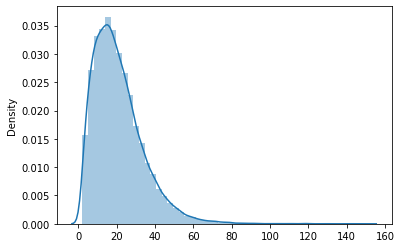

In [ ]:
EDA(web, tokenizer = get_tokenizer('spacy'))

전체 문장 수 : 38510
전체 단어 수 : 51475
문장 평균 단어 수 : 20.348
문장 최대 최소 단어 수 : (112, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


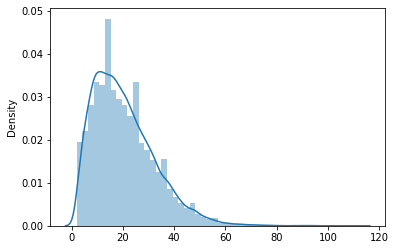

In [ ]:
EDA(new, tokenizer = get_tokenizer('spacy'))

In [ ]:
tokenized_corpus, vocab = make_final_corpus(corpus)

In [ ]:
def comparing_tokenizer(corpus, tokenizer, basic = False, tweet = False):
  corpus = sum(corpus, [])
  file_preprocessed = [preprocessing(sentence) for sentence in corpus]
  corpus_list = sum(file_preprocessed, [])
  if basic:
    if tweet:
      result = [tokenizer.tokenize(sent) for sent in corpus_list]
    else:
      result = [tokenizer().tokenize(sent) for sent in corpus_list]
  else:
    result = [tokenizer(sent) for sent in corpus_list]

  return result

In [ ]:
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
spacy = comparing_tokenizer(corpus, tokenizer = get_tokenizer('spacy'))
treebank = comparing_tokenizer(corpus, tokenizer = TreebankWordTokenizer, basic = True)

In [ ]:
tweet1 = comparing_tokenizer(corpus, tokenizer = TweetTokenizer(), basic = True, tweet = True)
tweet2 = comparing_tokenizer(corpus, tokenizer = TweetTokenizer(strip_handles = True, reduce_len = True), basic = True, tweet = True)

In [ ]:
from nltk import word_tokenize
word_token = comparing_tokenizer(corpus, tokenizer = word_tokenize)

In [ ]:
from keras.preprocessing.text import text_to_word_sequence
keras_ = comparing_tokenizer(corpus, tokenizer = text_to_word_sequence)

In [ ]:
import numpy as np
def comparing_text(tokenized):
  rand_ = np.random.randint(0, len(tokenized.keys()))
  print(rand_)
  for key, value in tokenized.items():
    print(key)
    print(value[rand_])
    print("-"*30)

In [ ]:
comparing_text({'spacy' : spacy, 'word_token' : word_token, "treebank" : treebank, "tweet1" : tweet1, 'tweet2' : tweet2, 'keras' : keras_})

0
spacy
['Iran', "'s", 'Nuclear', 'Program', ' ', 'A', 'former', 'deputy', 'defense', 'minister', ',', 'Ali', '-', 'Reza', 'Asgari', ',', 'disappeared', 'while', 'visiting', 'Turkey', 'in', '#', 'NUM#NUM#NUM#NUM', 'and', 'is', 'widely', 'believed', 'to', 'have', 'defected', ',', 'possibly', 'to', 'the', 'United', 'States', '.']
------------------------------
word_token
['Iran', "'s", 'Nuclear', 'Program', 'A', 'former', 'deputy', 'defense', 'minister', ',', 'Ali-Reza', 'Asgari', ',', 'disappeared', 'while', 'visiting', 'Turkey', 'in', '#', 'NUM', '#', 'NUM', '#', 'NUM', '#', 'NUM', 'and', 'is', 'widely', 'believed', 'to', 'have', 'defected', ',', 'possibly', 'to', 'the', 'United', 'States', '.']
------------------------------
treebank
['Iran', "'s", 'Nuclear', 'Program', 'A', 'former', 'deputy', 'defense', 'minister', ',', 'Ali-Reza', 'Asgari', ',', 'disappeared', 'while', 'visiting', 'Turkey', 'in', '#', 'NUM', '#', 'NUM', '#', 'NUM', '#', 'NUM', 'and', 'is', 'widely', 'believed', 'to

In [ ]:
y = cleaned

' <a href= " http : **29;4784;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " ><img src= " http : **30;4815;TOOLONG ... width= " 500 " height= " 333 " alt= " They realized that they were wearing the same outfit " ></a>  <a href= " http : **29;4847;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " ><img src= " http : **30;4878;TOOLONG ... width= " 100 " height= " 67 " alt= " They realized that they were wearing the same outfit " ></a>  url=http : **30;4910;TOOLONG ... url=http : **30;4942;TOOLONG ... realized that they were wearing the same outfit/url by url=http : **30;4974;TOOLONG ... on Flickr  <a href= " http : **29;5006;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " ><img src= " http : **30;5037;TOOLONG ... width= " 75 " height= " 75 " alt= " They realized that they were wearing the same outfit " ></a>  url=http : **30;5069;TOOLONG ... url=http : **30;5101;TOOLO

In [ ]:
x[11]

'p'

In [ ]:
x.split("<p>")

['@@5081141 ',
 ' &lt;a href= " http : **29;4784;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " &gt;&lt;img src= " http : **30;4815;TOOLONG ... width= " 500 " height= " 333 " alt= " They realized that they were wearing the same outfit " &gt;&lt;/a&gt; ',
 ' &lt;a href= " http : **29;4847;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " &gt;&lt;img src= " http : **30;4878;TOOLONG ... width= " 100 " height= " 67 " alt= " They realized that they were wearing the same outfit " &gt;&lt;/a&gt; ',
 ' url=http : **30;4910;TOOLONG ... url=http : **30;4942;TOOLONG ... realized that they were wearing the same outfit/url by url=http : **30;4974;TOOLONG ... on Flickr ',
 ' &lt;a href= " http : **29;5006;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " &gt;&lt;img src= " http : **30;5037;TOOLONG ... width= " 75 " height= " 75 " alt= " They realized that they were wearing the same

In [ ]:
x

'@@5081141 <p> &lt;a href= " http : **29;4784;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " &gt;&lt;img src= " http : **30;4815;TOOLONG ... width= " 500 " height= " 333 " alt= " They realized that they were wearing the same outfit " &gt;&lt;/a&gt; <p> &lt;a href= " http : **29;4847;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " &gt;&lt;img src= " http : **30;4878;TOOLONG ... width= " 100 " height= " 67 " alt= " They realized that they were wearing the same outfit " &gt;&lt;/a&gt; <p> url=http : **30;4910;TOOLONG ... url=http : **30;4942;TOOLONG ... realized that they were wearing the same outfit/url by url=http : **30;4974;TOOLONG ... on Flickr <p> &lt;a href= " http : **29;5006;TOOLONG ... title= " realized that they were wearing the same outfit by Anz-i , Flickr " &gt;&lt;img src= " http : **30;5037;TOOLONG ... width= " 75 " height= " 75 " alt= " They realized that they were wearing the same outfit "

# 0. 휴지통

In [ ]:
### OLD VERSION
############################################################
############################################################
import nltk 
import re
nltk.download('punkt')

def preprocessing(corpus):
  # 전처리 코드 전체 
  # input : 문서 리스트
  # output : 문서 리스트

  if not len(corpus) < 5: # 글자가 5개 이하인 경우 아예 지움. \r\n과 같은 개행 문자를 삭제해줌
    corpus = re.sub(r"\<.\>", "", corpus) # <p>나 <h> 삭제 
    corpus = re.sub(r"[0-9]", "#NUM", corpus) # 2020년 01월 -> ####년 ##월
    corpus = re.sub(r"\( .* \)", "", corpus) # 괄호 안 문장 삭제라 조심해서 사용할 것. 
    # corpus = re.sub(r"[A-Z][.A-Z]*", "", corpus)
    corpus_split_by_sent = nltk.tokenize.sent_tokenize(corpus) # 문장 단위로 나눔.  #I.A.E.E 나 C.I.A.를 문장으로 끊고 있음
    corpus_id = corpus_split_by_sent[0].split(" ")[0] # corpus_id를 따로 저장
    corpus_split_by_sent[0] = re.sub("(@{2}[0-9]{7} )",  "", corpus_split_by_sent[0]) # corpus_id를 지움
    result_corpus = []
    for sent in corpus_split_by_sent:
      if (len(sent) > 5) and (sent.find("@ @ @ @ @ @ @ @ @ @") == -1): # corpus 내부에서 길이가 짧은 문장이나 개행 문자 제거, @로 마스킹된 단어가 있는 문장 제거 
        # result_corpus.append("@@" + corpus_id + "@ " + sent) # 문장 맨 앞에 $$corpus_id@ 추가 
        result_corpus.append(sent)
    return result_corpus

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
import nltk 
import re

nltk.download('punkt')

def preprocessing(corpus, sentence_splitter = nltk.tokenize.sent_tokenize):
  # 전처리 코드 전체 
  # input : 문서 리스트
  # output : 문서 리스트
  corpus = re.sub(r"\<.\>", "", corpus) # <p>나 <h> 삭제 
  corpus = re.sub(r"[0-9]", "#NUM", corpus) # 2020년 01월 -> ####년 ##월
  corpus = re.sub(r"\( .* \)", "", corpus) # 괄호 안 문장 삭제라 조심해서 사용할 것. 
  # corpus = re.sub(r"[A-Z][.A-Z]*", "", corpus)
  corpus_split_by_sent = sentence_splitter(corpus) # 문장 단위로 나눔.  #I.A.E.E 나 C.I.A.를 문장으로 끊고 있음
  corpus_split_by_sent[0] = re.sub(r"@@[0-9]{7} ", "", corpus_split_by_sent[0]) # corpus_id 삭제
  result_corpus = []
  for sent in corpus_split_by_sent:
    if (len(sent) > 5) and (sent.find("@ @ @ @ @ @ @ @ @ @") == -1): # corpus 내부에서 길이가 짧은 문장이나 개행 문자 제거, @로 마스킹된 단어가 있는 문장 제거 
      result_corpus.append(sent)
  return result_corpus

In [ ]:
# EDA 함수들

# 출처 : https://pytorch.org/tutorials/beginner/torchtext_translation_tutorial.html
from collections import Counter
from torchtext.vocab import Vocab
from torchtext.data.utils import get_tokenizer
def count_words(corpus, counter = Counter(), tokenizer = get_tokenizer('spacy')):
  for sent in corpus:
    counter.update(en_tokenizer(sent))
  return counter, Vocab(counter)
def tokenizing(corpus, vocab, tokenizer):
  result = []
  for sent in corpus:
    sent_tokens = [vocab[token] for token in tokenizer(sent)]
    result.append(sent_tokens)
  return result
def sumUptheWordsCount(corpus):
  sum_ = 0
  for sent in corpus:
    sum_ += len(sent) 
  return sum_

전체 문장 수 : 82411
전체 단어 수 : 43096


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


문장 평균 단어 수 : 14.444


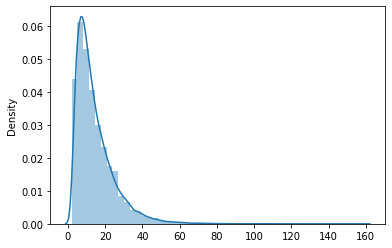

In [ ]:
EDA(fic)

전체 문장 수 : 168111
전체 단어 수 : 41652


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


문장 평균 단어 수 : 8.285


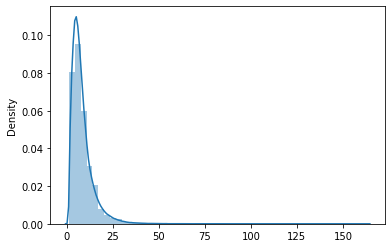

In [ ]:
EDA(tvm)